In [1]:
import numpy as np
import torch 
import gym 
from torch import nn
import matplotlib.pyplot as plt


In [2]:
def t(x):
    return torch.from_numpy(x).float()

In [3]:
class Actor(nn.Module):
    def __init__(self, state_dim, n_actions):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64,32),
            nn.Tanh(),
            nn.Linear(32, n_actions),
            nn.Softmax()
        )
    def forward(self, X):
        return self.model(X)
        

In [4]:
class Critic(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,1)
        )
    def forward(self, X):
        return self.model(X)
    

In [5]:
# Memory
# stores results from the networks, instead of calculating the 
# operations again from the states
class Memory():
    def __init__(self):
        self.log_probs = []
        self.values = []
        self.rewards = []
        self.dones = []

    def add(self, log_prob, value, reward, done):
        self.log_probs.append(log_prob)
        self.values.append(value)
        self.rewards.append(reward)
        self.dones.append(done)
    
    def clear(self):
        self.log_probs.clear()
        self.values.clear()
        self.rewards.clear()
        self.dones.clear()
    
    def _zip(self):
        return zip(self.log_probs,
                   self.values,
                   self.rewards,
                   self.dones)
    def __iter__(self):
        for data in self._zip():
            return data
    def reversed(self):
        for data in list(self._zip())[::-1]:
            yield data
    def __len__(self):
        return len(self.rewards)
    


In [6]:
env = gym.make("CartPole-v1")

/home/bunnybhaiya/.local/lib/python3.10/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/bunnybhaiya/.local/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [7]:
state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n
actor = Actor(state_dim, n_actions)
critic = Critic(state_dim)
adam_actor = torch.optim.Adam(actor.parameters(), lr=1e-3)
adam_critic = torch.optim.Adam(critic.parameters(), lr=1e-3)
gamma = 0.99
memory = Memory()
max_step = 200


In [13]:
def train(memory, q_val):
    values = torch.stack(memory.values)
    q_vals = np.zeros((len(memory), 1))

    #target values are calculated backwards
    # super important to handle correctly done states
    # for those cases we want our target to be equal to the reward only
    for i, (_, _, reward, done) in enumerate(memory.reversed()):
        q_val = reward + gamma*q_val*(1.0 - done)
        q_vals[len(memory)-1 -i] = q_val # store values from the end to the beginning

    advantage = torch.Tensor(q_vals) - values

    critic_loss = advantage.pow(2).mean()
    adam_critic.zero_grad()
    critic_loss.backward()
    adam_critic.step()

    actor_loss = (-torch.stack(memory.log_probs)*(advantage.detach())).mean()
    adam_actor.zero_grad()
    actor_loss.backward()
    adam_actor.step()
    

In [14]:
episode_rewards = []
for i in range(500):
    done = False
    total_reward = 0
    state = env.reset()
    steps = 0

    while not done:
        probs = actor(t(state))
        dist = torch.distributions.Categorical(probs=probs)
        action = dist.sample()
        next_state, reward, done, info = env.step(action.detach().data.numpy())
        total_reward += reward
        steps += 1
        memory.add(dist.log_prob(action), critic(t(state)), reward, done)
        
        state = next_state

        if done or (steps % max_step == 0):
            last_q_val = critic(t(next_state)).detach().data.numpy()
            train(memory, last_q_val)
            memory.clear()
    episode_rewards.append(total_reward)

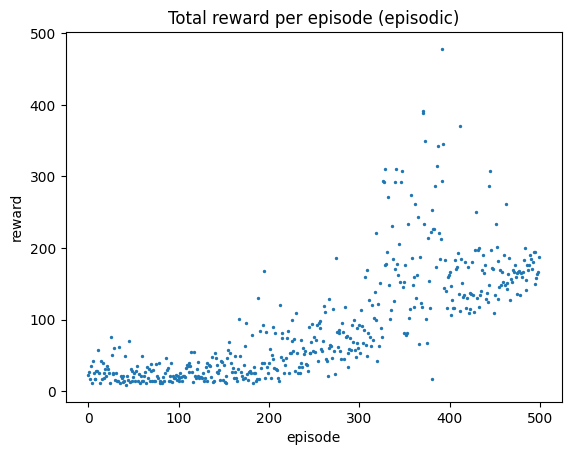

In [15]:
plt.scatter(np.arange(len(episode_rewards)), episode_rewards, s=2)
plt.title("Total reward per episode (episodic)")
plt.ylabel("reward")
plt.xlabel("episode")
plt.show()